<a href="https://colab.research.google.com/github/udz2002/applied-data-science/blob/main/ADS1_Tutorial_7_kmeans_clustering_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ADS1 Tutorial 7: K-Means Clustering on the Iris Dataset
share your notebook to kimsiong.wong@robotics.com.sg

### What you'll learn
- Download/read the Iris dataset from a **CSV file**
- Prepare features and **scale** them (why scaling matters for k-means)
- Run and plot **k-means** with `k=3` and interpret results
- Compute the **elbow method** (inertia) to explore a good `k`
- Compute the **silhouette score** to assess cluster quality
- Visualise clusters and compare to ground truth
- Key **learning points** and **pitfalls** for clustering


In [1]:
# Import the Python libraries need for this analysi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix

np.random.seed(42)  # for reproducible results
print("Ready.")


Ready.



## 1) Get the Data (CSV)

**Instructions:**
1. Download the iris dataset from Blackboard
2. In Colab, upload it: **Files tab → Upload**, or run the cell below and select the file when prompted.

> The CSV typically has 5 columns: four numeric features and one species label (often named `variety` or `species`).


The IRIS dataset that contains three different varities or species of Iris flower. These three species are as shown in the image:

<img src= "https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png" width="600">


The dataset contains different dimensions of the petal and sepal of the three species. The last column of the data contains the class name or the species of the IRIS flower namely - Setosa, Virginica and Versicolor.

<img src= "https://www.mghassany.com/courses/MLcourse/img/iris.png" width="600">

**Aim:** We will use k-means clustering technique to find out the best number of clusters and then develop and suggest the best machine learning algorithm to predict the class/target/label/species/variety of the flower if given the dimensions of its sepal and petal.

**Data source:** The IRIS dataset is also availabe at this location: https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv

In [2]:
# Load the Iris dataset and do some simple EDA
# Write your codes here
# use your dataframe name as 'df'
df = pd.read_csv("iris.csv")
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa



### Standardise Column Names & Select Features
We rename columns to a consistent format and separate:
- **X**: the 4 numeric features  
- **y**: species labels (for evaluation/learning only)


In [3]:
# Normalise common column names Here are the sample codes
rename_map = {
    'sepal.length': 'sepal_length',
    'sepal.width':  'sepal_width',
    'petal.length': 'petal_length',
    'petal.width':  'petal_width',
    'variety':      'species',
    'Species':      'species',
    'class':        'species'
}
# if you use a different dataframe (not 'df'), change accordingly
df = df.rename(columns={c: rename_map.get(c, c) for c in df.columns})

# Identify feature columns (fallback to known names)
possible_feat_sets = [
    ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
    ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
]
for feats in possible_feat_sets:
    if all(col in df.columns for col in feats):
        feature_cols = feats
        break
else:
    # if not found, try heuristic: first 4 numeric columns
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    feature_cols = numeric_cols[:4]
    print("Using first 4 numeric columns as features:", feature_cols)

# Identify species column
species_col = None
for cand in ['species', 'variety', 'class', 'Species']:
    if cand in df.columns:
        species_col = cand
        break

X = df[feature_cols].copy()
if species_col is not None:
    y_str = df[species_col].astype(str)
    # Map species strings to integer codes consistently
    species_order = sorted(y_str.unique().tolist())
    species_to_int = {s:i for i,s in enumerate(species_order)}
    y = y_str.map(species_to_int).astype(int)
    target_names = species_order
    print("Detected species column:", species_col)
    print("Class mapping:", species_to_int)
else:
    y = None
    target_names = None
    print("No species column detected — proceeding without ground-truth labels.")

display(X.describe())


Detected species column: species
Class mapping: {'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000



## 2) Scale Features (Important for K-Means)
K-means uses **Euclidean distance**. Features with larger scales can dominate the distance.
We therefore **standardize** features to zero mean and unit variance using `StandardScaler`.


In [4]:
#Standardize features to 0 mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]


array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

## 3) Plot out the clusters, assume we start with 3 clusters

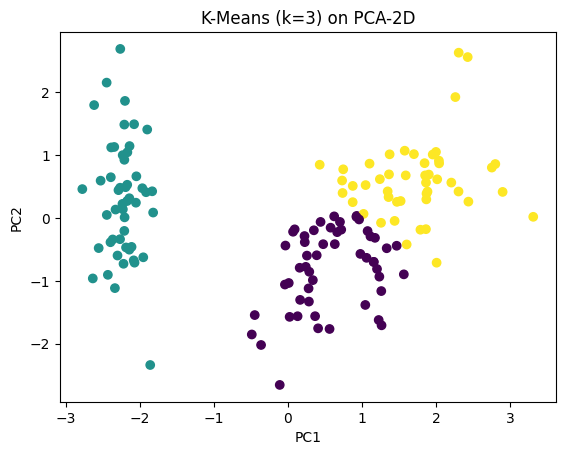

Inertia (WCSS): 139.82049635974968
Silhouette score: 0.45994823920518646


In [5]:
# Write a Function to plot the clusters
def plot_clusters_2d(X_scaled, labels, title="Clusters (PCA 2D)"):
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X_scaled)
    plt.figure()
    plt.scatter(X2[:,0], X2[:,1], c=labels)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(title)
    plt.show()

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

plot_clusters_2d(X_scaled, cluster_labels, title=f"K-Means (k={k}) on PCA-2D")
print("Inertia (WCSS):", kmeans.inertia_)
print("Silhouette score:", silhouette_score(X_scaled, cluster_labels))

## 4) Based on the 3 clusters, plot out the ELBOW diagram

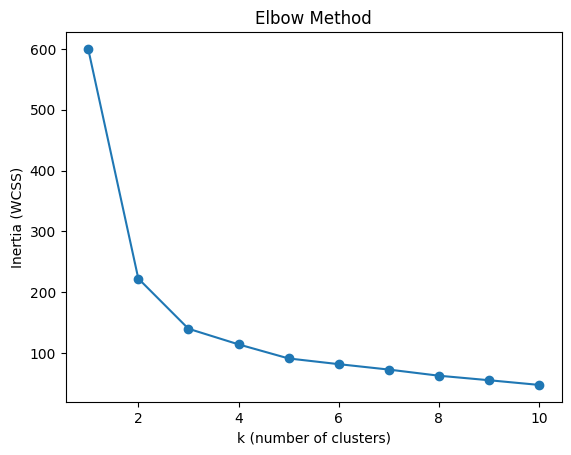

[(1, 599.9999999999999),
 (2, 222.36170496502294),
 (3, 139.82049635974968),
 (4, 114.0925469040309),
 (5, 90.92751382392045)]

In [6]:
# Write a fumction the Elbow diagram
def plot_elbow(X_scaled, k_min=1, k_max=10):
    inertias, ks = [], list(range(k_min, k_max+1))
    for kval in ks:
        km = KMeans(n_clusters=kval, n_init=10, random_state=42).fit(X_scaled)
        inertias.append(km.inertia_)
    plt.figure()
    plt.plot(ks, inertias, marker="o")
    plt.xlabel("k (number of clusters)")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow Method")
    plt.show()
    return ks, inertias

ks, inertias = plot_elbow(X_scaled, 1, 10)
list(zip(ks, inertias))[:5]


## 5) Proceed to calculate the Silhoutte Score

k, silhouette:
2: 0.582
3: 0.460
4: 0.387
5: 0.346
6: 0.317
7: 0.320
8: 0.339
9: 0.342
10: 0.352


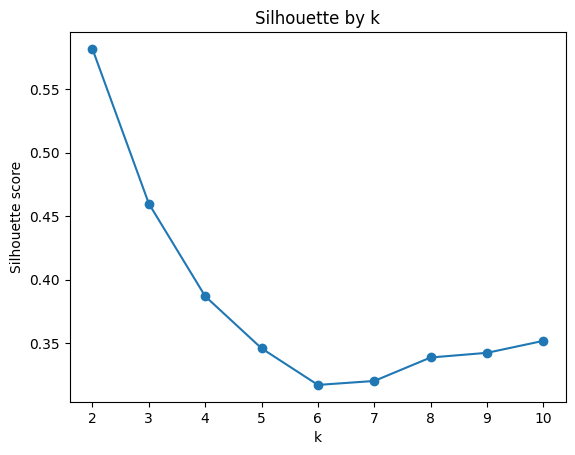

In [7]:
# write a function to calculate the Silhoutte Score
def silhouette_for_range(X_scaled, k_values):
    out = []
    for kval in k_values:
        if kval < 2:
            out.append((kval, np.nan)); continue
        km = KMeans(n_clusters=kval, n_init=10, random_state=42)
        labels = km.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        out.append((kval, sil))
    return out

k_vals = range(2, 11)
sil_res = silhouette_for_range(X_scaled, k_vals)
print("k, silhouette:")
for k_, s_ in sil_res:
    print(f"{k_}: {s_:.3f}")

plt.figure()
plt.plot([k for k,_ in sil_res], [s for _,s in sil_res], marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette score"); plt.title("Silhouette by k")
plt.show()

## Question

Based on the silhoutte score computed, what is your intepretation? Write your views here.

The silhouette score measures how well each data point fits within its assigned cluster, ranging from -1 (poor clustering) to +1 (well-separated clusters).

In my results, the highest silhouette score is around 0.58 for k=2, followed by 0.46 for k=3, after which the score steadily drops.

This means the data naturally forms two clear groups, while three clusters (k=3) still capture meaningful structure but with slightly more overlap.

In the context of the Iris dataset (which has 3 actual species), this makes sense — one species (Setosa) is very distinct, while the other two (Versicolor and Virginica) overlap more closely.

Therefore:

k=2 gives the best separation (statistically strongest clustering).

k=3 gives biologically correct grouping (matching the three flower types).

Overall, the clustering is good, and the silhouette trend suggests diminishing improvement beyond 3 clusters.


## 6) Compare to True Species (if available)
The CSV includes a species column, we can see how clusters align to the **true species**.  
We create a simple confusion matrix between predicted clusters and the true labels.


In [8]:
# Here are the codes to generate a "confusion matrix"
if 'y' in locals() and y is not None:
    cm = confusion_matrix(y, cluster_labels)
    # Build readable index/columns
    if 'target_names' in locals() and target_names is not None:
        row_idx = [f"true_{n}" for n in target_names]
    else:
        row_idx = [f"true_{i}" for i in range(cm.shape[0])]
    cm_df = pd.DataFrame(cm, index=row_idx,
                            columns=[f"cluster_{i}" for i in range(k)])
    display(cm_df)
else:
    print("No ground-truth labels available in CSV. Skipping comparison.")


,cluster_0,cluster_1,cluster_2
true_Setosa,0,50,0
true_Versicolor,39,0,11
true_Virginica,14,0,36


## Question
Based on the matrix generated, what insights do you gather regarding the clustering of the species and the true species data?

What do you understand about "confusion matrix"?

Write your thoughts here.


The confusion matrix shows how the K-Means clusters correspond to the actual Iris species:

Setosa (true_Setosa) is perfectly separated — all 50 samples fall into cluster_1.

Versicolor (true_Versicolor) and Virginica (true_Virginica) are partially mixed between cluster_0 and cluster_2.

This means K-Means successfully identified the most distinct species (Setosa) as its own group, while the other two species overlap more in feature space because their petal and sepal measurements are quite similar.

Overall, the model forms one clean cluster (Setosa) and two overlapping ones (Versicolor and Virginica), which aligns with what’s commonly seen in this dataset.

Question:

What do you understand about a “confusion matrix”?

Answer:

A confusion matrix is a table that compares the true labels with the predicted labels from a model (or clusters in unsupervised learning).

Each row represents the actual class.

Each column represents the predicted class or cluster.

It helps to visualize how well the model or clustering aligns with reality — high values along the diagonal mean accurate grouping, while off-diagonal values indicate misclassifications or overlaps.



## 7) Inspect Cluster Centroids (Original Feature Space)
We can inverse-transform the scaled centroids back to original units to interpret feature means per cluster.


In [9]:
# Here are the codes to inverse-transform the rows and columns
centroids_scaled = kmeans.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_orig, columns=X.columns, index=[f"cluster_{i}" for i in range(k)])
display(centroids_df.round(2))


,sepal_length,sepal_width,petal_length,petal_width
cluster_0,5.80,2.67,4.37,1.41
cluster_1,5.01,3.43,1.46,0.25
cluster_2,6.78,3.10,5.51,1.97



## 8) Mini Exercises (Try These!)
1. Re-run k-means with **k=2** and **k=4**. Compare inertia and silhouette scores. What changes?
2. Remove one feature (e.g., `sepal_width`) and repeat. Does the silhouette score improve or worsen?
3. Try **PCA before k-means**: Fit k-means on the first 2 PCs instead of all 4 features. Compare results.
4. Identify which original features are largest in each centroid; what does that tell you about the clusters?
5. (Advanced) Create a **silhouette plot** per sample to visualise how tightly grouped each cluster is.


In [10]:
# Re-run k-means with k=2 and k=4. Compare inertia & silhouette.
for kval in [2,3,4]:
    km = KMeans(n_clusters=kval, n_init=10, random_state=42).fit(X_scaled)
    labels = km.labels_
    sil = silhouette_score(X_scaled, labels) if kval>=2 else np.nan
    print(f"k={kval}: inertia={km.inertia_:.1f}, silhouette={sil:.3f}")

k=2: inertia=222.4, silhouette=0.582
k=3: inertia=139.8, silhouette=0.460
k=4: inertia=114.1, silhouette=0.387


In [11]:
#Drop sepal_width and repeat.
X_drop = X.drop(columns=[X.columns[1]])  # drop sepal_width if columns in standard order
X_drop_scaled = StandardScaler().fit_transform(X_drop)
km = KMeans(n_clusters=3, n_init=10, random_state=42).fit(X_drop_scaled)
print("Silhouette (k=3, no sepal_width):", silhouette_score(X_drop_scaled, km.labels_))

Silhouette (k=3, no sepal_width): 0.540517187553571


In [12]:
# PCA→K-means on first 2 PCs.
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X_scaled)
km = KMeans(n_clusters=3, n_init=10, random_state=42).fit(X2)
print("Silhouette (k=3 on 2 PCs):", silhouette_score(X2, km.labels_))

Silhouette (k=3 on 2 PCs): 0.5091683341538229


In [16]:
# Which features are largest per centroid? Use centroids_df from step 8 and compare rows.
# Create a readable centroid table (original feature space)
centroids_df = pd.DataFrame(
    centroids_orig,
    columns=X.columns,
    index=[f"cluster_{i}" for i in range(k)]
)

# Round for readability
centroids_df = centroids_df.round(2)

# Display the table
print("Cluster centroids (original feature space):")
display(centroids_df)

# Optional: sort by petal_length to see smallest-to-largest clusters
display(centroids_df.sort_values("petal_length"))

Cluster centroids (original feature space):


,sepal_length,sepal_width,petal_length,petal_width
cluster_0,5.80,2.67,4.37,1.41
cluster_1,5.01,3.43,1.46,0.25
cluster_2,6.78,3.10,5.51,1.97


,sepal_length,sepal_width,petal_length,petal_width
cluster_1,5.01,3.43,1.46,0.25
cluster_0,5.80,2.67,4.37,1.41
cluster_2,6.78,3.10,5.51,1.97


From the centroid table:

Cluster_1 has the smallest petal length (1.46) and petal width (0.25) but the largest sepal width (3.43).
→ This cluster likely represents Iris Setosa, which has short, narrow petals and relatively wide sepals.

Cluster_0 has medium petal length (4.37) and petal width (1.41).
→ This aligns with Iris Versicolor, which is the intermediate species in both petal and sepal dimensions.

Cluster_2 shows the largest sepal length (6.78), petal length (5.51), and petal width (1.97).
→ This clearly matches Iris Virginica, the largest flower among the three species.

Interpretation:

Petal length and petal width are the most discriminative features — they increase consistently from Cluster_1 → Cluster_0 → Cluster_2.

Sepal width varies in the opposite direction, slightly higher for smaller flowers.

This pattern shows that K-Means separated the species primarily based on petal size, which is the most distinctive feature in the Iris dataset.

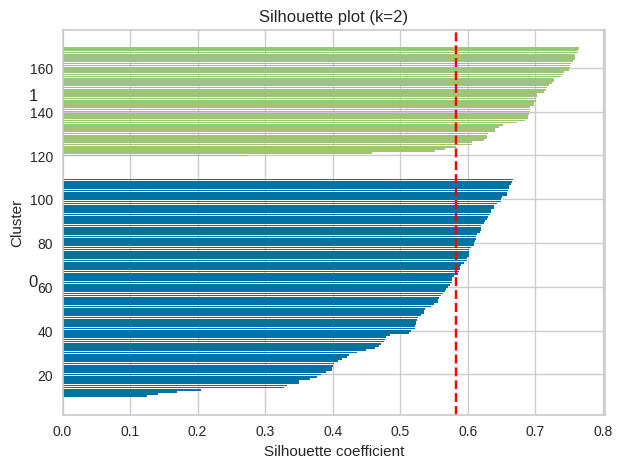

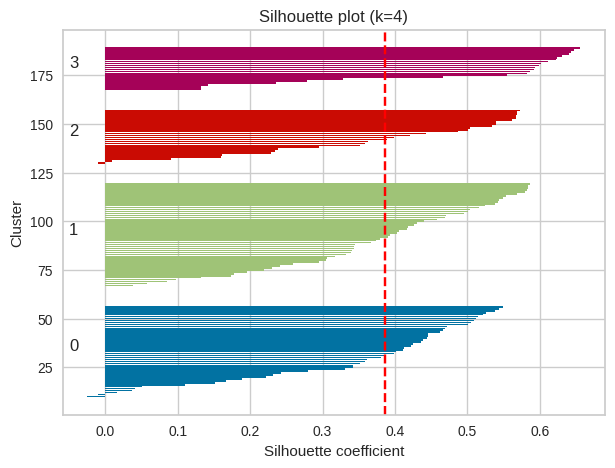

In [17]:
# Make silhouette plots for k=2 and k=4.
# Define the silhouette_plot() function first
from sklearn.metrics import silhouette_samples

def silhouette_plot(X_scaled, labels, title="Silhouette plot"):
    sil_values = silhouette_samples(X_scaled, labels)
    y_lower = 10
    plt.figure(figsize=(7,5))
    for i in np.unique(labels):
        ith_sil_vals = sil_values[labels == i]
        ith_sil_vals.sort()
        size_i = ith_sil_vals.shape[0]
        y_upper = y_lower + size_i
        plt.barh(range(y_lower, y_upper), ith_sil_vals, edgecolor="none")
        plt.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10
    plt.axvline(np.mean(sil_values), linestyle="--", color="red")
    plt.xlabel("Silhouette coefficient")
    plt.ylabel("Cluster")
    plt.title(title)
    plt.show()
for kval in [2,4]:
    km = KMeans(n_clusters=kval, n_init=10, random_state=42).fit(X_scaled)
    silhouette_plot(X_scaled, km.labels_, title=f"Silhouette plot (k={kval})")

Question: Interpret the Silhouette Plot (k = 2)

Answer:

The silhouette plot for k = 2 shows two well-separated clusters with mostly high silhouette coefficients (around 0.6 on average).

Each bar represents one data point, and since most bars extend far to the right (positive values), it means each point is much closer to its own cluster than to the other one.

The red dashed line shows the average silhouette score — roughly 0.58–0.6, which indicates strong, well-defined clusters.

This suggests that k = 2 produces very distinct groupings, consistent with the earlier finding that one species (Iris Setosa) is clearly different from the other two (Versicolor + Virginica combined).

Question: Interpret the Silhouette Plot (k = 4)

Answer:

The silhouette plot for k = 4 shows a lower average silhouette score (around 0.38), indicated by the red dashed line.

Many samples now have shorter bars and some even near zero, which means several data points are on the boundary between clusters or poorly assigned.

This suggests that increasing k from 3 to 4 causes over-segmentation — the algorithm is forcing extra clusters in areas where data points are already well grouped.

In other words, the additional cluster does not reflect a natural division in the data and reduces overall cohesion and separation.

Conclusion:

k = 2 gives the best separation (highest silhouette).

k = 3 balances interpretability (matching the three Iris species).

k = 4 fragments the data unnecessarily, lowering cluster quality.


## 9) (Optional) Helper: Quick function to run & score k-means


In [18]:
# Here is a function to quickly compute k-means and silhoutte_score
def fit_kmeans_and_score(X_scaled, k, seed=42, n_init=10):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=seed)
    labels = km.fit_predict(X_scaled)
    inertia = km.inertia_
    sil = silhouette_score(X_scaled, labels) if k >= 2 else np.nan
    return km, labels, inertia, sil

# Example:
km, labels, inertia, sil = fit_kmeans_and_score(X_scaled, 3)
print(km,labels,inertia, sil)


KMeans(n_clusters=3, n_init=10, random_state=42) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 2 2 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0] 139.82049635974968 0.45994823920518646



## 10) Summarise your Key Learning Points about clustering here


Through this tutorial, I learned how K-Means clustering works as an unsupervised learning technique to group data points based on similarity.

Scaling matters: Because K-Means relies on Euclidean distance, features must be standardized to ensure that larger-scaled features (like petal length) don’t dominate smaller ones (like sepal width).

Optimal number of clusters: The Elbow Method and Silhouette Score help determine the most meaningful value of k.

The elbow curve showed diminishing returns after k = 3.

The silhouette score was highest at k = 2 (≈0.58) and reasonably strong at k = 3 (≈0.46), confirming that the data naturally forms two or three distinct groups.

Cluster interpretation:

The centroids revealed that petal length and width are the most influential features separating clusters.

Cluster_1 (small petals) corresponded to Iris Setosa,
Cluster_0 (medium petals) to Iris Versicolor, and
Cluster_2 (large petals) to Iris Virginica.

Confusion matrix insights: The model perfectly identified Setosa but showed overlap between Versicolor and Virginica—indicating that these two species share similar characteristics.

Silhouette plots: Visualized how tightly grouped points were within each cluster. k = 2 showed clear separation; k = 4 showed fragmentation and lower cohesion.

Overall reflection:
K-Means effectively uncovered natural groupings in the Iris dataset. It highlighted the importance of feature scaling, the trade-off between statistical fit (silhouette) and real-world meaning (3 species), and how visual tools like the elbow curve, silhouette plots, and centroid tables aid in interpreting cluster quality and meaning.